In [1610]:
import tensorflow as tf
# from tensorflow.python.client import device_lib
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Importing Libraries 

In [1712]:
import nibabel as nib
import numpy as np
from scipy import ndimage
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D,Flatten,Dense,PReLU,BatchNormalization,GlobalAveragePooling2D,GlobalAvgPool2D,InputLayer,MaxPooling2D,Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG16,VGG19,ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# 
# import nipype.interfaces.fsl as fsl

# Data Processing 

In [2529]:

# Define directory paths
train_dir = 'Full Processed Data/Training'
val_dir = 'Full Processed Data/Validation'
test_dir = 'Full Processed Data/Testing'


# Set hyperparameters
img_size = (150, 150)  # image size to resize to
batch_size = 128        # number of images to process at a time

# Define data generators with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,      # normalize pixel values between 0 and 1
     fill_mode='constant',
     cval=0,  # set constant value to 0 (black)
     rotation_range=45,   # randomly rotate images up to 20 degrees
    width_shift_range=0.15,   # randomly shift images horizontally up to 20% of the width
      height_shift_range=0.15,   # randomly shift images vertically up to 20% of the height
    zoom_range=0.25,   
       horizontal_flip=True,   # randomly flip images horizontally
     vertical_flip=True  , # don
     shear_range=0.9,
      channel_shift_range=0.99,
 brightness_range=(0.2, 1.8),

)


val_datagen = ImageDataGenerator(
    rescale=1./255,

    )
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
        shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator_predict = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

)

Found 27204 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 2946 images belonging to 3 classes.
Found 2946 images belonging to 3 classes.


c:\Users\PC\anaconda3\envs\alzheimer\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\PC\anaconda3\envs\alzheimer\lib\site-packages\keras\preprocessing\image.py:1886: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


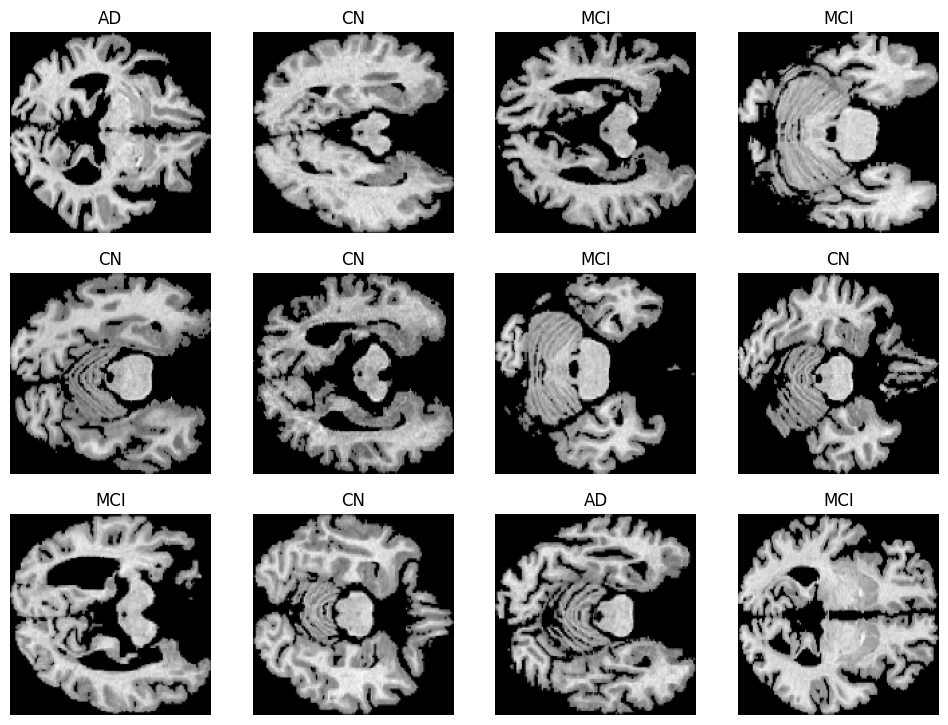

(150, 150, 3)


In [2528]:

# Get a batch of images and labels from the train generator
x_batch, y_batch = next(train_generator)
class_names = list(train_generator.class_indices.keys())

# Plot the images and their corresponding labels
plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_batch[i])
    plt.title(class_names[y_batch[i].argmax()])
    plt.axis('off')
plt.show()
print(x_batch[0].shape)


# VGG16

In [ ]:
#commment it and don't run it when you load model 

input_shape=[150,150,3]
# Load the pretrained VGG16 model
base_model=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pretrained model
for layer in base_model.layers[:-15]:
   layer.trainable = False
    #freeze all layers
# for layer in base_model.layers:
#     layer.trainable = False

# Add new classification layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout with a rate of 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout with a rate of 
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)  # Add dropout with a rate of 
# # x = Dense(128, activation='relu',kernel_regularizer='l2')(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)  # Add dropout with a rate of 

# x = Dense(64, activation='relu', kernel_regularizer='l2')(x)
# x = Dropout(0.5)(x)  # Add dropout with a rate of 

# x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Print the model summary
model.summary()

In [1715]:
# Calculate class weights to balance the dataset
class_counts = np.array([len(train_generator.labels[train_generator.labels == i]) for i in range(train_generator.num_classes)])
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))}
print('Class weights:', class_weights)

Class weights: {0: 1.8136, 1: 1.1793471192612823, 2: 0.6247330347915949}


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)


# with tpu_strategy.scope():

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=20,restore_best_weights=True)

# Train the model, doing validation at the end of each epoch
epochs = 40
# Fit the model.

with tf.device('/GPU'):
    model.fit(
                    train_generator,
                    #calcualte it
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=epochs,
                    validation_data=val_generator,
                    #calculate it 
                    validation_steps=STEP_SIZE_VALID,
                    shuffle=True,
                    verbose=2,
                    callbacks=[checkpoint_cb, early_stopping_cb],
                    class_weight=class_weights
              )


In [2495]:
# remove compile =False in kaggel + uncomment it
model = load_model('best_test_acc_VGG16(97.86%).h5',compile=False)


In [2490]:
# Freeze the layers of the pretrained model
for layer in model.layers[:-10]:
   layer.trainable = False

In [2496]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)


# with tpu_strategy.scope():

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=20,restore_best_weights=True)


In [2530]:
with tf.device('/GPU'):
    model.fit  (
                    train_generator,
                    #calcualte it
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=15,
                    validation_data=val_generator,
                    #calculate it 
                    validation_steps=STEP_SIZE_VALID,
                    shuffle=True,
                    verbose=2,
                    callbacks=[checkpoint_cb],
                     class_weight=class_weights
                ) 
    

Epoch 1/15
212/212 - 100s - loss: 0.8644 - acc: 0.5737 - val_loss: 0.0783 - val_acc: 0.9766 - 100s/epoch - 474ms/step
Epoch 2/15
212/212 - 99s - loss: 0.8527 - acc: 0.5661 - val_loss: 0.0851 - val_acc: 0.9766 - 99s/epoch - 469ms/step
Epoch 3/15
212/212 - 100s - loss: 0.8569 - acc: 0.5650 - val_loss: 0.0861 - val_acc: 0.9772 - 100s/epoch - 471ms/step
Epoch 4/15
212/212 - 100s - loss: 0.8486 - acc: 0.5667 - val_loss: 0.0859 - val_acc: 0.9762 - 100s/epoch - 471ms/step
Epoch 5/15
212/212 - 100s - loss: 0.8505 - acc: 0.5657 - val_loss: 0.0882 - val_acc: 0.9772 - 100s/epoch - 471ms/step
Epoch 6/15
212/212 - 100s - loss: 0.8452 - acc: 0.5695 - val_loss: 0.0856 - val_acc: 0.9769 - 100s/epoch - 469ms/step
Epoch 7/15
212/212 - 100s - loss: 0.8560 - acc: 0.5611 - val_loss: 0.0862 - val_acc: 0.9769 - 100s/epoch - 472ms/step
Epoch 8/15
212/212 - 100s - loss: 0.8510 - acc: 0.5665 - val_loss: 0.0855 - val_acc: 0.9766 - 100s/epoch - 472ms/step
Epoch 9/15
212/212 - 100s - loss: 0.8548 - acc: 0.5644 - v

In [2429]:
# fig, ax = plt.subplots(1, 2,figsize=(20, 3))
# ax = ax.ravel()
# for i, metric in enumerate(["acc", "loss"]):
#     ax[i].plot(model.history.history[metric])
#     ax[i].plot(model.history.history["val_" + metric])
#     ax[i].set_title("Model {}".format(metric))
#     ax[i].set_xlabel("epochs")
#     ax[i].set_ylabel(metric)
#     ax[i].legend(["train", "val"])

# Testing Model

In [2519]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

print('Test loss:', test_loss)

print('Test accuracy:', test_acc)

# Get the predictions for the test set
y_pred = model.predict(test_generator_predict, steps=len(test_generator))

# Convert the predictions from one-hot encoded vectors to class labels
class_names = list(test_generator.class_indices.keys())
y_pred_labels = [class_names[i] for i in y_pred.argmax(axis=1)]

# Get the true class labels for the test set

y_true_labels = test_generator.classes
y_true_labels = [class_names[i] for i in y_true_labels]

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels))

24/24 [==============================] - 3s 119ms/step - loss: 0.0676 - acc: 0.9786
Test loss: 0.06755569577217102
Test accuracy: 0.9786150455474854
24/24 [==============================] - 3s 119ms/step
              precision    recall  f1-score   support

          AD       0.99      0.95      0.97       946
          CN       0.99      0.99      0.99      1000
         MCI       0.96      0.99      0.97      1000

    accuracy                           0.98      2946
   macro avg       0.98      0.98      0.98      2946
weighted avg       0.98      0.98      0.98      2946



In [2499]:

model.save('best_test_acc_VGG16(97.%).h5')

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)

# Print the classification report with accuracy per class
print("Classification report:")
for class_name in class_names:
    print(f"Class {class_name}:")
    print(f"  Accuracy: {report[class_name]['precision']:.4f}")
    print(f"  Precision: {report[class_name]['precision']:.4f}")
    print(f"  Recall: {report[class_name]['recall']:.4f}")
    print(f"  F1-score: {report[class_name]['f1-score']:.4f}")

Classification report:
Class AD:
  Accuracy: 0.9955
  Precision: 0.9955
  Recall: 0.9450
  F1-score: 0.9696
Class CN:
  Accuracy: 0.9840
  Precision: 0.9840
  Recall: 0.9870
  F1-score: 0.9855
Class MCI:
  Accuracy: 0.9464
  Precision: 0.9464
  Recall: 0.9890
  F1-score: 0.9672


In [ ]:
from sklearn.metrics import accuracy_score

# Get the true class labels for the test set
y_true = test_generator.classes

# Get the predicted class labels for the test set
y_pred = model.predict(test_generator_predict).argmax(axis=1)

# Calculate the overall test accuracy
test_accuracy = accuracy_score(y_true, y_pred)

# Calculate the test accuracy per class
class_accuracy = {}
for class_index in range(len(class_names)):
    # Get the indices of samples for this class
    indices = np.where(y_true == class_index)[0]
    # Get the true labels and predicted labels for this class
    y_true_class = y_true[indices]
    y_pred_class = y_pred[indices]
    # Calculate the accuracy for this class
    class_accuracy[class_names[class_index]] = accuracy_score(y_true_class, y_pred_class)

# Print the overall test accuracy and test accuracy


24/24 [==============================] - 3s 123ms/step


In [ ]:
# Print the overall test accuracy and test accuracy per class
print("Overall test accuracy:", test_accuracy)
print("Test accuracy per class:")
for class_name in class_names:
    print(f"Class {class_name}: {class_accuracy[class_name]:.4f}")

Overall test accuracy: 0.8839103869653768
Test accuracy per class:
Class AD: 0.8985
Class CN: 0.8990
Class MCI: 0.8550


In [2060]:
model1 = load_model('best_test_acc_VGG16(97.79%).h5',compile=False)
model2 = load_model('best_test_acc_VGG16(97.76%).h5',compile=False)
model3 = load_model('best_test_acc_VGG16(97.73%).h5',compile=False)


In [2061]:
preds1 = model1.predict(test_generator_predict)
preds2 = model2.predict(test_generator_predict)
preds3 = model3.predict(test_generator_predict)
final_preds = np.argmax(np.sum([preds1, preds2, preds3], axis=0), axis=1)

# Convert the predictions from one-hot encoded vectors to class labels
# class_names = list(test_generator.class_indices.keys())
# y_pred_labels = [class_names[i] for i in y_pred.argmax(axis=1)]

# Get the true class labels for the test set
# y_true_labels = test_generator.classes
# # y_true_labels = [class_names[i] for i in y_true_labels]
# print(y_pred.argmax(axis=1))
# print(accuracy_score(y_true_labels,y_pred.argmax(axis=1)))
# # Print the classification report
# print(classification_report(y_true_labels, y_pred_labels))

24/24 [==============================] - 3s 114ms/step


In [2062]:
y_true_labels = test_generator.classes
# y_true_labels = [class_names[i] for i in y_true_labels]

print(accuracy_score(y_true_labels,final_preds))

0.9775967413441955


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


47/47 [==============================] - 13s 278ms/step - loss: 0.3853 - acc: 0.8839
Test loss: 0.385270357131958
Test accuracy: 0.8839103579521179


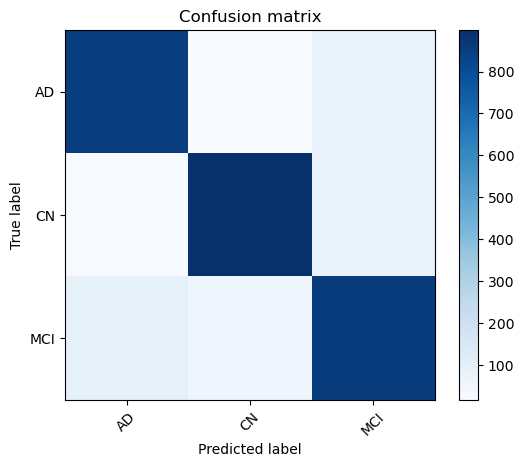

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred.argmax(axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(range(3), class_names, rotation=45)
plt.yticks(range(3), class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

[0 0 0 ... 2 2 2]


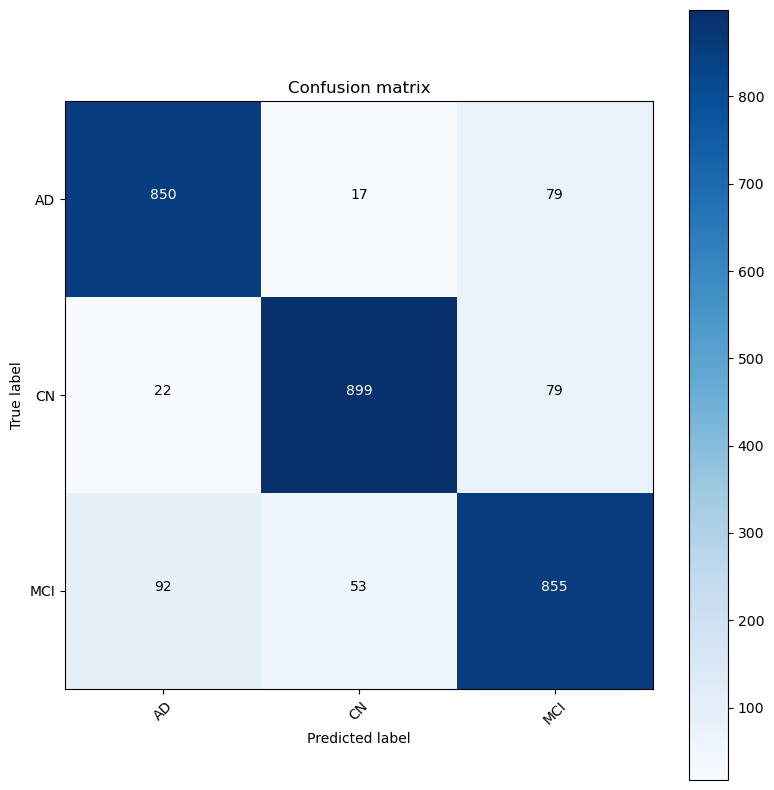

In [ ]:
from itertools import product
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    # cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# cm= tf.math.confusion_matrix(
#     labels=tf.argmax(labels, 1), predictions=tf.argmax(predictions, 1),
#     num_classes=3)
test_pred = np.argmax(y_pred, axis=1)
print(test_pred)
# Calculate the confusion matrix using sklearn.metrics
cm = confusion_matrix(y_true_labels, test_pred)
plot_confusion_matrix(cm, class_names=class_names)